In [1]:
#quiskit
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise
from qiskit_experiments.framework.experiment_data import ExperimentData

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
# Set devices, if using a real device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')

In [4]:
sim = Aer.get_backend('aer_simulator')

In [5]:
def make_chsh_circuit(theta_vec):#for each theta in theta_vec[], 
    #returns the quantum circuit required to do the measuremet
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0) #hadamard
            qc.cx(0, 1) #cnot
            qc.ry(theta, 0) #rotation theta along y axes
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

In [6]:
def compute_chsh_witness(counts):#compute exp values for the inequality,
    #for each theta required
    
    # Order is ZZ,ZX,XZ,XX
    CHSH = []
    
    = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chshplus = 0
        chshminus = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            if parity == 1:
                chshplus+= zz[element]
            else:
                chshminus+= zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            if parity == 1:
                chshplus+= zx[element]
            else:
                chshminus+= zx[element]


        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            if parity == 1:
                chshminus+= xz[element]
            else:
                chshplus+= xz[element]


        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            if parity == 1:
                chshplus+= xx[element]
            else:
                chshminus+= xx[element]


        CHSH.append((chshplus-chshminus)/no_shots)
        Var.append(np.var(np.concatenate((np.ones(chshplus),np.negative(np.ones(chshminus))), axis=None)))
    
    return CHSH, Var

In [7]:
number_of_thetas = 25
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

In [8]:
# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()

tic = time.time()

In [9]:
transpiled_circuits = transpile(my_chsh_circuits, quito)
job_real = quito.run(transpiled_circuits, shots=8192)
job_monitor(job_real)
result_real = job_real.result()

Job Status: job has successfully run


In [10]:
toc = time.time()

print(toc-tic)

1405.5460731983185


In [11]:
CHSH_ideal, Var_ideal = compute_chsh_witness(result_ideal.get_counts())

In [12]:
CHSH_real, Var_real = compute_chsh_witness(result_real.get_counts())

In [13]:
#x-axis
stepsx = np.arange(0, 2 * np.pi+np.pi/4, step=(np.pi / 4))
labelsx=[0]
for i in range(len(stepsx)-1):
    if (i+1)%2!=0:
        label=str(i+1)+"π/4"
        if (i+1)==1:
                label='π/4'
    else:
        labeli=(i+1)
        if labeli%4==0:
            label=str(int(labeli/4))+'π'
            if labeli/4==1:
                label='π'
        else:
            label=str(int(labeli/2))+'π/2'
            if labeli/2==1:
                label='π/2'
    labelsx.append(label)

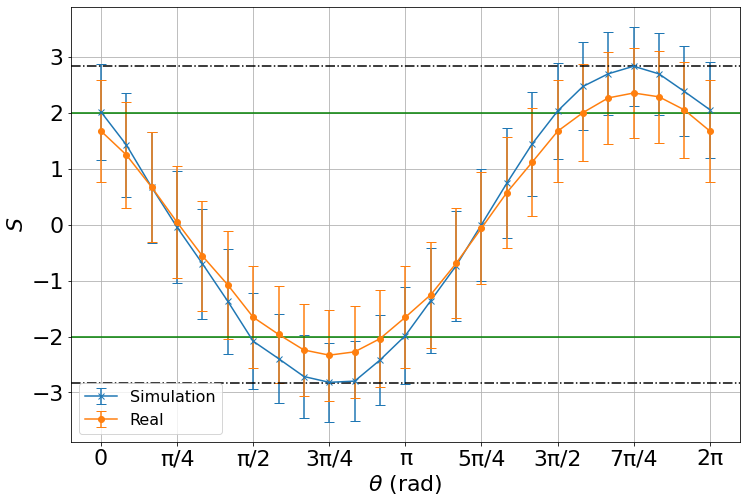

In [23]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})

plt.errorbar(theta_vec,CHSH_ideal,yerr=np.sqrt(Var_ideal),fmt='x-',capsize=5 ,label = 'Simulation')
plt.errorbar(theta_vec,CHSH_real,yerr=np.sqrt(Var_real), fmt='o-',capsize=5 ,label = 'Real')




plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='lower left')
plt.axhline(y=2, color='g', linestyle='-')
plt.axhline(y=-2, color='g', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')

plt.xticks(stepsx, labelsx)
plt.xlabel(r'$\theta$ (rad)')
plt.ylabel(r'$S$')
plt.plot()
plt.savefig('name.pdf')

In [14]:
print(theta_vec)

[0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 3.66519143 3.92699082 4.1887902  4.45058959
 4.71238898 4.97418837 5.23598776 5.49778714 5.75958653 6.02138592
 6.28318531]


In [15]:
print(CHSH_ideal)

[1.970703125, 1.416015625, 0.73046875, 0.02734375, -0.75390625, -1.443359375, -1.947265625, -2.451171875, -2.693359375, -2.765625, -2.767578125, -2.603515625, -1.96875, -1.3515625, -0.6953125, -0.02734375, 0.748046875, 1.439453125, 1.947265625, 2.486328125, 2.76171875, 2.771484375, 2.703125, 2.5546875, 1.9296875]


In [16]:
print(CHSH_real)

[1.68603515625, 1.260009765625, 0.70458984375, 0.0537109375, -0.537109375, -1.1220703125, -1.645263671875, -2.007568359375, -2.24267578125, -2.3583984375, -2.30859375, -2.0849609375, -1.677001953125, -1.251220703125, -0.678466796875, -0.06787109375, 0.565185546875, 1.09912109375, 1.6640625, 2.043701171875, 2.309814453125, 2.34130859375, 2.306396484375, 2.08056640625, 1.70361328125]


In [17]:
print(Var_real)

[0.8223303407430649, 0.900773461908102, 0.9689720720052719, 0.9998196959495544, 0.9819695949554443, 0.9213098883628845, 0.8308192156255245, 0.7481043301522732, 0.6856503337621689, 0.6523723006248474, 0.6668996810913086, 0.7283086180686951, 0.8242290280759335, 0.9021529220044613, 0.9712301753461361, 0.9997120946645737, 0.9800353311002254, 0.9244958013296127, 0.8269309997558594, 0.738955345004797, 0.6665473245084286, 0.6573921293020248, 0.667533453553915, 0.7294527143239975, 0.818606361746788]


In [18]:
print(Var_ideal)

[0.7572705745697021, 0.8746812343597412, 0.9666509628295898, 0.9999532699584961, 0.9644765853881836, 0.8697946071624756, 0.763009786605835, 0.6244847774505615, 0.5466134548187256, 0.5219573974609375, 0.5212819576263428, 0.5763566493988037, 0.75775146484375, 0.8858299255371094, 0.9697837829589844, 0.9999532699584961, 0.9650266170501709, 0.8704984188079834, 0.763009786605835, 0.613635778427124, 0.5233068466186523, 0.5199296474456787, 0.5433197021484375, 0.5920982360839844, 0.7672691345214844]
